# Assignment 2 for OpenMMLab Camp 2 2023

By Yuming Liu @jercylew
Updated: 2023/6/11

# 0. Env setup


Keep using the drive disk, the data, config, and source are located in google drive, so mound the google drive each time run this notebook

In [16]:
# Mount google drive
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
# Now enter the workspace in google drive
import os
os.chdir('/content/drive/MyDrive/workspace')
!pwd

/content/drive/MyDrive/workspace


Install dependencies

In [18]:
# Upgrade numpy
# Trick for upgrading numpy, fuck ^_^
!pip install -U numpy 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [19]:
# Pytorch
!pip install install torch torchvision torchaudio -f https://download.pytorch.org/whl/cu113/torch_stable.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/cu113/torch_stable.html


In [20]:
# MMCV via MIM
!pip install -U openmim
!mim install mmengine
!mim install 'mmcv==2.0.0rc3'
!mim install "mmdet>=3.0.0rc6"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.openmmlab.com/mmcv/dist/cu118/torch2.0.0/index.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.openmmlab.com/mmcv/dist/cu118/torch2.0.0/index.html
  Using cached mmcv-2.0.0rc3-cp310-cp310-linux_x86_64.whl
  Attempting uninstall: mmcv
    Found existing installation: mmcv 2.0.0
    Uninstalling mmcv-2.0.0:
      Successfully uninstalled mmcv-2.0.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mmdet 3.0.0 requires mmcv<2.1.0,>=2.0.0rc4, but you have mmcv 2.0.0rc3 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-py

In [21]:
# Other necessary packages
!pip install opencv-python pillow matplotlib seaborn tqdm pycocotools -i https://pypi.tuna.tsinghua.edu.cn/simple

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [22]:
# Environment check and display
from mmengine.utils import get_git_hash
from mmengine.utils.dl_utils import collect_env as collect_base_env

import mmdet

# 环境信息收集和打印
def collect_env():
    """Collect the information of the running environments."""
    env_info = collect_base_env()
    env_info['MMDetection'] = f'{mmdet.__version__}+{get_git_hash()[:7]}'
    return env_info


if __name__ == '__main__':
    for name, val in collect_env().items():
        print(f'{name}: {val}')

sys.platform: linux
Python: 3.10.12 (main, Jun  7 2023, 12:45:35) [GCC 9.4.0]
CUDA available: True
numpy_random_seed: 2147483648
GPU 0: Tesla T4
CUDA_HOME: /usr/local/cuda
NVCC: Cuda compilation tools, release 11.8, V11.8.89
GCC: x86_64-linux-gnu-gcc (Ubuntu 9.4.0-1ubuntu1~20.04.1) 9.4.0
PyTorch: 2.0.1+cu118
PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2022.2-Product Build 20220804 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.7.3 (Git Hash 6dbeffbae1f23cbbeae17adb7b5b13f1f37c080e)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.8
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch=compute_70,code=sm_70;-gencode;arch=compute_75,code=sm_75;-gencode;arch=compute_80,code=sm_80;-

# 1. Data Collection

In [23]:
os.chdir('/content/drive/MyDrive/workspace/mmdetection/data')
!pwd

/content/drive/MyDrive/workspace/mmdetection/data


In [ ]:
# !rm -rf cat_dataset*
# !wget https://download.openmmlab.com/mmyolo/data/cat_dataset.zip
# !unzip cat_dataset.zip -d cat_dataset && rm cat_dataset.zip 

**Convert to COCO style dataset**

In [ ]:
import os.path as osp

import mmcv

from mmengine.fileio import dump, load
from mmengine.utils import track_iter_progress


def convert_balloon_to_coco(ann_file, out_file, image_prefix):
    data_infos = load(ann_file)

    annotations = []
    images = []
    obj_count = 0
    for idx, v in enumerate(track_iter_progress(data_infos.values())):
        filename = v['filename']
        img_path = osp.join(image_prefix, filename)
        height, width = mmcv.imread(img_path).shape[:2]

        images.append(
            dict(id=idx, file_name=filename, height=height, width=width))

        for _, obj in v['regions'].items():
            assert not obj['region_attributes']
            obj = obj['shape_attributes']
            px = obj['all_points_x']
            py = obj['all_points_y']
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            x_min, y_min, x_max, y_max = (min(px), min(py), max(px), max(py))

            data_anno = dict(
                image_id=idx,
                id=obj_count,
                category_id=0,
                bbox=[x_min, y_min, x_max - x_min, y_max - y_min],
                area=(x_max - x_min) * (y_max - y_min),
                segmentation=[poly],
                iscrowd=0)
            annotations.append(data_anno)
            obj_count += 1

    coco_format_json = dict(
        images=images,
        annotations=annotations,
        categories=[{
            'id': 0,
            'name': 'balloon'
        }])
    dump(coco_format_json, out_file)



convert_balloon_to_coco(ann_file='balloon/train/via_region_data.json',
                        out_file='balloon/train/annotation_coco.json',
                        image_prefix='balloon/train')
convert_balloon_to_coco(ann_file='balloon/val/via_region_data.json',
                        out_file='balloon/val/annotation_coco.json',
                        image_prefix='balloon/val')


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 61/61, 1.8 task/s, elapsed: 33s, ETA:     0s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 13/13, 1.9 task/s, elapsed: 7s, ETA:     0s


# 2. Data Visualization

In [24]:
import os
import matplotlib.pyplot as plt
from PIL import Image

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

original_images = []
images = []
texts = []
plt.figure(figsize=(16, 5))

image_paths= [filename for filename in os.listdir('balloon/train')][:8]

for i,filename in enumerate(image_paths):
    name = os.path.splitext(filename)[0]

    image = Image.open('balloon/train/'+filename).convert("RGB")
  
    plt.subplot(2, 4, i+1)
    plt.imshow(image)
    plt.title(f"{filename}")
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()

Output hidden; open in https://colab.research.google.com to view.

In [25]:
# Using COCO toolbox to visulaize the iamges
from pycocotools.coco import COCO
import numpy as np
import os.path as osp
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon

def apply_exif_orientation(image):
    _EXIF_ORIENT = 274
    if not hasattr(image, 'getexif'):
        return image

    try:
        exif = image.getexif()
    except Exception:
        exif = None

    if exif is None:
        return image

    orientation = exif.get(_EXIF_ORIENT)

    method = {
        2: Image.FLIP_LEFT_RIGHT,
        3: Image.ROTATE_180,
        4: Image.FLIP_TOP_BOTTOM,
        5: Image.TRANSPOSE,
        6: Image.ROTATE_270,
        7: Image.TRANSVERSE,
        8: Image.ROTATE_90,
    }.get(orientation)
    if method is not None:
        return image.transpose(method)
    return image


def show_bbox_only(coco, anns, show_label_bbox=True, is_filling=True):
    """Show bounding box of annotations Only."""
    if len(anns) == 0:
        return

    ax = plt.gca()
    ax.set_autoscale_on(False)

    image2color = dict()
    for cat in coco.getCatIds():
        image2color[cat] = (np.random.random((1, 3)) * 0.7 + 0.3).tolist()[0]

    polygons = []
    colors = []

    for ann in anns:
        color = image2color[ann['category_id']]
        bbox_x, bbox_y, bbox_w, bbox_h = ann['bbox']
        poly = [[bbox_x, bbox_y], [bbox_x, bbox_y + bbox_h],
                [bbox_x + bbox_w, bbox_y + bbox_h], [bbox_x + bbox_w, bbox_y]]
        polygons.append(Polygon(np.array(poly).reshape((4, 2))))
        colors.append(color)

        if show_label_bbox:
            label_bbox = dict(facecolor=color)
        else:
            label_bbox = None

        ax.text(
            bbox_x,
            bbox_y,
            '%s' % (coco.loadCats(ann['category_id'])[0]['name']),
            color='white',
            bbox=label_bbox)

    if is_filling:
        p = PatchCollection(
            polygons, facecolor=colors, linewidths=0, alpha=0.4)
        ax.add_collection(p)
    p = PatchCollection(
        polygons, facecolor='none', edgecolors=colors, linewidths=2)
    ax.add_collection(p)

    
coco = COCO('balloon/val/annotation_coco.json')
image_ids = coco.getImgIds()
np.random.shuffle(image_ids)

plt.figure(figsize=(16, 5))

# 只可视化 8 张图片
for i in range(8):
    image_data = coco.loadImgs(image_ids[i])[0]
    image_path = osp.join('balloon/val/',image_data['file_name'])
    annotation_ids = coco.getAnnIds(
            imgIds=image_data['id'], catIds=[], iscrowd=0)
    annotations = coco.loadAnns(annotation_ids)
    
    ax = plt.subplot(2, 4, i+1)
    image = Image.open(image_path).convert("RGB")
    
    # 这行代码很关键，否则可能图片和标签对不上
    image=apply_exif_orientation(image)
    
    ax.imshow(image)
    
    show_bbox_only(coco, annotations)
    
    plt.title(f"{filename}")
    plt.xticks([])
    plt.yticks([])
        
plt.tight_layout()    

Output hidden; open in https://colab.research.google.com to view.

# 3. Write config file

In [29]:
os.chdir('/content/drive/MyDrive/workspace/mmdetection/projects')
!pwd

if not os.path.exists('balloon-detect-demo'):
    os.mkdir('balloon-detect-demo')

os.chdir('balloon-detect-demo')

config_balloon = """
_base_ = '../../configs/rtmdet/rtmdet_tiny_8xb32-300e_coco.py'

data_root = '../../data/balloon/'

# 非常重要
metainfo = {
    # 类别名，注意 classes 需要是一个 tuple，因此即使是单类，
    # 你应该写成 `cat,` 很多初学者经常会在这犯错
    'classes': ('balloon',),
    'palette': [
        (220, 20, 60),
    ]
}
num_classes = 1

# 训练 40 epoch
max_epochs = 40
# 训练单卡 bs= 12
train_batch_size_per_gpu = 12
# 可以根据自己的电脑修改
train_num_workers = 4

# 验证集 batch size 为 1
val_batch_size_per_gpu = 1
val_num_workers = 2

# RTMDet 训练过程分成 2 个 stage，第二个 stage 会切换数据增强 pipeline
num_epochs_stage2 = 5

# batch 改变了，学习率也要跟着改变， 0.004 是 8卡x32 的学习率
base_lr = 12 * 0.004 / (32*8)

# 采用 COCO 预训练权重
load_from = 'https://download.openmmlab.com/mmdetection/v3.0/rtmdet/rtmdet_tiny_8xb32-300e_coco/rtmdet_tiny_8xb32-300e_coco_20220902_112414-78e30dcc.pth'  # noqa

model = dict(
    # 考虑到数据集太小，且训练时间很短，我们把 backbone 完全固定
    # 用户自己的数据集可能需要解冻 backbone
    backbone=dict(frozen_stages=4),
    # 不要忘记修改 num_classes
    bbox_head=dict(dict(num_classes=num_classes)))

# 数据集不同，dataset 输入参数也不一样
train_dataloader = dict(
    batch_size=train_batch_size_per_gpu,
    num_workers=train_num_workers,
    pin_memory=False,
    dataset=dict(
        data_root=data_root,
        metainfo=metainfo,
        ann_file='train/annotation_coco.json',
        data_prefix=dict(img='train/')))

val_dataloader = dict(
    batch_size=val_batch_size_per_gpu,
    num_workers=val_num_workers,
    dataset=dict(
        metainfo=metainfo,
        data_root=data_root,
        ann_file='val/annotation_coco.json',
        data_prefix=dict(img='val/')))

test_dataloader = val_dataloader

# 默认的学习率调度器是 warmup 1000，但是 cat 数据集太小了，需要修改 为 30 iter
param_scheduler = [
    dict(
        type='LinearLR',
        start_factor=1.0e-5,
        by_epoch=False,
        begin=0,
        end=30),
    dict(
        type='CosineAnnealingLR',
        eta_min=base_lr * 0.05,
        begin=max_epochs // 2,  # max_epoch 也改变了
        end=max_epochs,
        T_max=max_epochs // 2,
        by_epoch=True,
        convert_to_iter_based=True),
]
optim_wrapper = dict(optimizer=dict(lr=base_lr))

# 第二 stage 切换 pipeline 的 epoch 时刻也改变了
_base_.custom_hooks[1].switch_epoch = max_epochs - num_epochs_stage2

val_evaluator = dict(ann_file=data_root + 'val/annotation_coco.json')
test_evaluator = val_evaluator

# 一些打印设置修改
default_hooks = dict(
    checkpoint=dict(interval=10, max_keep_ckpts=2, save_best='auto'),  # 同时保存最好性能权重
    logger=dict(type='LoggerHook', interval=5))
train_cfg = dict(max_epochs=max_epochs, val_interval=10)
"""

with open('rtmdet_tiny_1xb12-40e_balloon.py', 'w') as f:
    f.write(config_balloon)

/content/drive/MyDrive/workspace/mmdetection/projects


# 4. Data check before training

我们可以采用 mmdet 提供的 tools/analysis_tools/browse_dataset.py 脚本来对训练前的 dataloader 输出进行可视化，确保数据部分没有问题。 考虑到我们仅仅想可视化前几张图片，因此下面基于 browse_dataset.py 实现一个简单版本即可

In [27]:
from mmdet.registry import DATASETS, VISUALIZERS
from mmengine.config import Config
from mmengine.registry import init_default_scope

cfg = Config.fromfile('rtmdet_tiny_1xb12-40e_balloon.py')

init_default_scope(cfg.get('default_scope', 'mmdet'))

dataset = DATASETS.build(cfg.train_dataloader.dataset)
visualizer = VISUALIZERS.build(cfg.visualizer)
visualizer.dataset_meta = dataset.metainfo

plt.figure(figsize=(16, 5))

# 只可视化前 8 张图片
for i in range(8):
   item=dataset[i]

   img = item['inputs'].permute(1, 2, 0).numpy()
   data_sample = item['data_samples'].numpy()
   gt_instances = data_sample.gt_instances
   img_path = osp.basename(item['data_samples'].img_path)

   gt_bboxes = gt_instances.get('bboxes', None)
   gt_instances.bboxes = gt_bboxes.tensor
   data_sample.gt_instances = gt_instances

   visualizer.add_datasample(
            osp.basename(img_path),
            img,
            data_sample,
            draw_pred=False,
            show=False)
   drawed_image=visualizer.get_image()

   plt.subplot(2, 4, i+1)
   plt.imshow(drawed_image[..., [2, 1, 0]])
   plt.title(f"{osp.basename(img_path)}")
   plt.xticks([])
   plt.yticks([])

plt.tight_layout()

Output hidden; open in https://colab.research.google.com to view.

# 5. Train the model

In [30]:
!python ../../tools/train.py rtmdet_tiny_1xb12-40e_balloon.py

06/11 15:41:38 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.10.12 (main, Jun  7 2023, 12:45:35) [GCC 9.4.0]
    CUDA available: True
    numpy_random_seed: 1177994201
    GPU 0: Tesla T4
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 11.8, V11.8.89
    GCC: x86_64-linux-gnu-gcc (Ubuntu 9.4.0-1ubuntu1~20.04.1) 9.4.0
    PyTorch: 2.0.1+cu118
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2022.2-Product Build 20220804 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.7.3 (Git Hash 6dbeffbae1f23cbbeae17adb7b5b13f1f37c080e)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.8
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50

# 6. Model Inference Test

In [32]:
os.chdir('/content/drive/MyDrive/workspace/mmdetection/projects/balloon-detect-demo')
!pwd
!python ../../tools/test.py ./rtmdet_tiny_1xb12-40e_balloon.py ./work_dirs/rtmdet_tiny_1xb12-40e_balloon/best_coco_bbox_mAP_epoch_30.pth

/content/drive/MyDrive/workspace/mmdetection/projects/balloon-detect-demo
06/11 15:57:05 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.10.12 (main, Jun  7 2023, 12:45:35) [GCC 9.4.0]
    CUDA available: True
    numpy_random_seed: 1489170433
    GPU 0: Tesla T4
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 11.8, V11.8.89
    GCC: x86_64-linux-gnu-gcc (Ubuntu 9.4.0-1ubuntu1~20.04.1) 9.4.0
    PyTorch: 2.0.1+cu118
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2022.2-Product Build 20220804 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.7.3 (Git Hash 6dbeffbae1f23cbbeae17adb7b5b13f1f37c080e)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.8
  - NVCC archit

In [33]:
# Also save the results
!python ../../tools/test.py ./rtmdet_tiny_1xb12-40e_balloon.py ./work_dirs/rtmdet_tiny_1xb12-40e_balloon/best_coco_bbox_mAP_epoch_30.pth --show-dir results

06/11 15:58:22 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.10.12 (main, Jun  7 2023, 12:45:35) [GCC 9.4.0]
    CUDA available: True
    numpy_random_seed: 112409783
    GPU 0: Tesla T4
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 11.8, V11.8.89
    GCC: x86_64-linux-gnu-gcc (Ubuntu 9.4.0-1ubuntu1~20.04.1) 9.4.0
    PyTorch: 2.0.1+cu118
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2022.2-Product Build 20220804 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.7.3 (Git Hash 6dbeffbae1f23cbbeae17adb7b5b13f1f37c080e)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.8
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,

Then we can visulaize the result images

In [34]:
# 数据集可视化

import os
import matplotlib.pyplot as plt
from PIL import Image

%matplotlib inline

plt.figure(figsize=(20, 20))

# 你如果重新跑，这个时间戳是不一样的，需要自己修改
root_path='work_dirs/rtmdet_tiny_1xb12-40e_balloon/20230611_155821/results/'
image_paths= [filename for filename in os.listdir(root_path)][:4]

for i,filename in enumerate(image_paths):
    name = os.path.splitext(filename)[0]

    image = Image.open(root_path+filename).convert("RGB")
  
    plt.subplot(4, 1, i+1)
    plt.imshow(image)
    plt.title(f"{filename}")
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()

Output hidden; open in https://colab.research.google.com to view.

Note: lefft is labelled, right is predicted image.
左边显示的是标注框，右边显示的是预测框。

实际上 MMDetection 支持多种可视化后端，例如 TensorBoard 和 WandB，默认情况下是将图片保存到本地，用户只需要修改可视化部分配置即可轻松切换。如下所示

以下配置只需要加到 `rtmdet_tiny_1xb12-40e_cat.py` 配置最后即可

**(1) 同时使用本地和 WandB 后端**

```python
visualizer = dict(vis_backends = [dict(type='LocalVisBackend'), dict(type='WandbVisBackend')])
```

**(2) 仅仅使用 TensorBoard 后端**

```python
visualizer = dict(vis_backends = [dict(type='TensorboardVisBackend')])
```
修改配置后重新运行 test.py 即可在 WandB 和 TensorBoard 前端界面查看 图片和 log 等。

如果想对单张图片进行推理，你可以直接使用 `mmdetection/demo/image_demo.py` 脚本

In [35]:
!python ../../demo/image_demo.py ../../data/balloon/test_inference/balloons_in_sky_1358170-2771241.jpg rtmdet_tiny_1xb12-40e_balloon.py --weights work_dirs/rtmdet_tiny_1xb12-40e_balloon/best_coco_bbox_mAP_epoch_30.pth

Loads checkpoint by local backend from path: work_dirs/rtmdet_tiny_1xb12-40e_balloon/best_coco_bbox_mAP_epoch_30.pth
06/11 16:13:51 - mmengine - WARNING - Failed to search registry with scope "mmdet" in the "function" registry tree. As a workaround, the current "function" registry in "mmengine" is used to build instance. This may cause unexpected failure when running the built modules. Please check whether "mmdet" is a correct scope, or whether the registry is initialized.
06/11 16:13:51 - mmengine - WARNING - `Visualizer` backend is not initialized because save_dir is None.
/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: 
torch.meshgrid: in an upcoming release, it will be required to pass the indexing
argument. (Triggered internally at 
../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Inference ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   
results have been saved at outputs


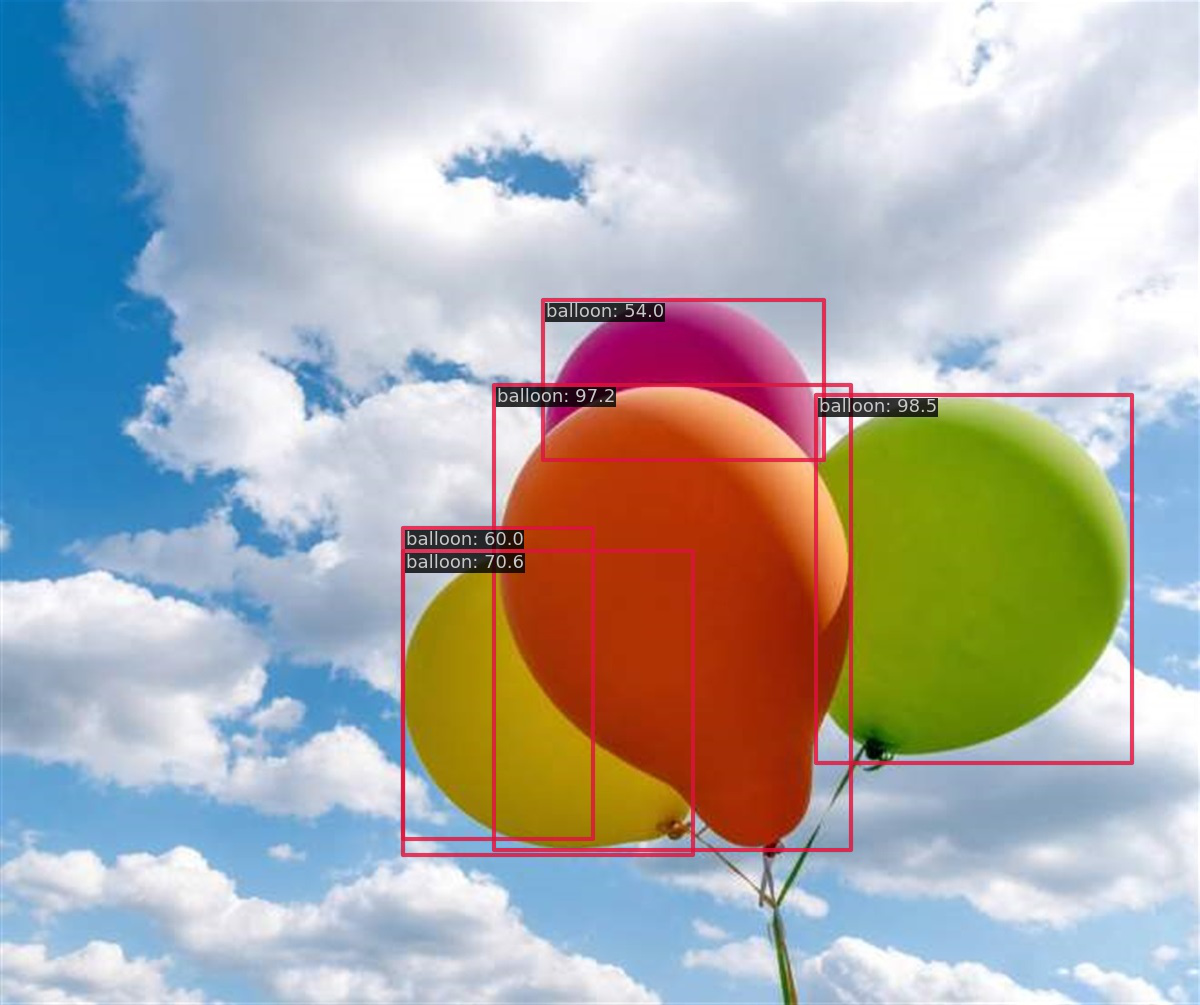

In [37]:
Image.open('outputs/vis/balloons_in_sky_1358170-2771241.jpg')

# 7. Analyze the results

Using MMYOLO tools to analyze the results

In [38]:
os.chdir('/content/drive/MyDrive/workspace/')
!pwd
!rm -rf mmyolo
# 为了防止后续更新导致的可能无法运行，特意新建了 tutorials 分支
!git clone -b tutorials https://github.com/open-mmlab/mmyolo.git 
os.chdir('mmyolo')

!mim install -e .
!pwd

/content/drive/MyDrive/workspace
Cloning into 'mmyolo'...
remote: Enumerating objects: 4898, done.
remote: Counting objects: 100% (290/290), done.
remote: Compressing objects: 100% (171/171), done.
remote: Total 4898 (delta 122), reused 234 (delta 114), pack-reused 4608
Receiving objects: 100% (4898/4898), 3.76 MiB | 12.28 MiB/s, done.
Resolving deltas: 100% (3005/3005), done.
Updating files: 100% (650/650), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.openmmlab.com/mmcv/dist/cu118/torch2.0.0/index.html
Obtaining file:///content/drive/MyDrive/workspace/mmyolo
  Preparing metadata (setup.py) ... done
  Running setup.py develop for mmyolo
/content/drive/MyDrive/workspace/mmyolo


Choose a image, and resize it if too large

In [39]:
import cv2

img = cv2.imread('../mmdetection/data/balloon/train/10464445726_6f1e3bbe6a_k.jpg')
h,w=img.shape[:2]
resized_img = cv2.resize(img, (640, 640))
cv2.imwrite('resized_image.jpg', resized_img)

True

可视化 backbone 输出的 3 个通道

Loads checkpoint by local backend from path: ../mmdetection/projects/balloon-detect-demo/work_dirs/rtmdet_tiny_1xb12-40e_balloon/best_coco_bbox_mAP_epoch_30.pth
06/11 16:28:43 - mmengine - WARNING - `Visualizer` backend is not initialized because save_dir is None.
[                                                  ] 0/1, elapsed: 0s, ETA:/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/usr/local/lib/python3.10/dist-packages/mmengine/visualization/visualizer.py:984: UserWarning: Since the spatial dimensions of overlaid_image: (640, 640) and featmap: torch.Size([80, 80]) are not same, the feature map will be interpolated. This may cause mismatch problems ！
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/mmengine/visuali

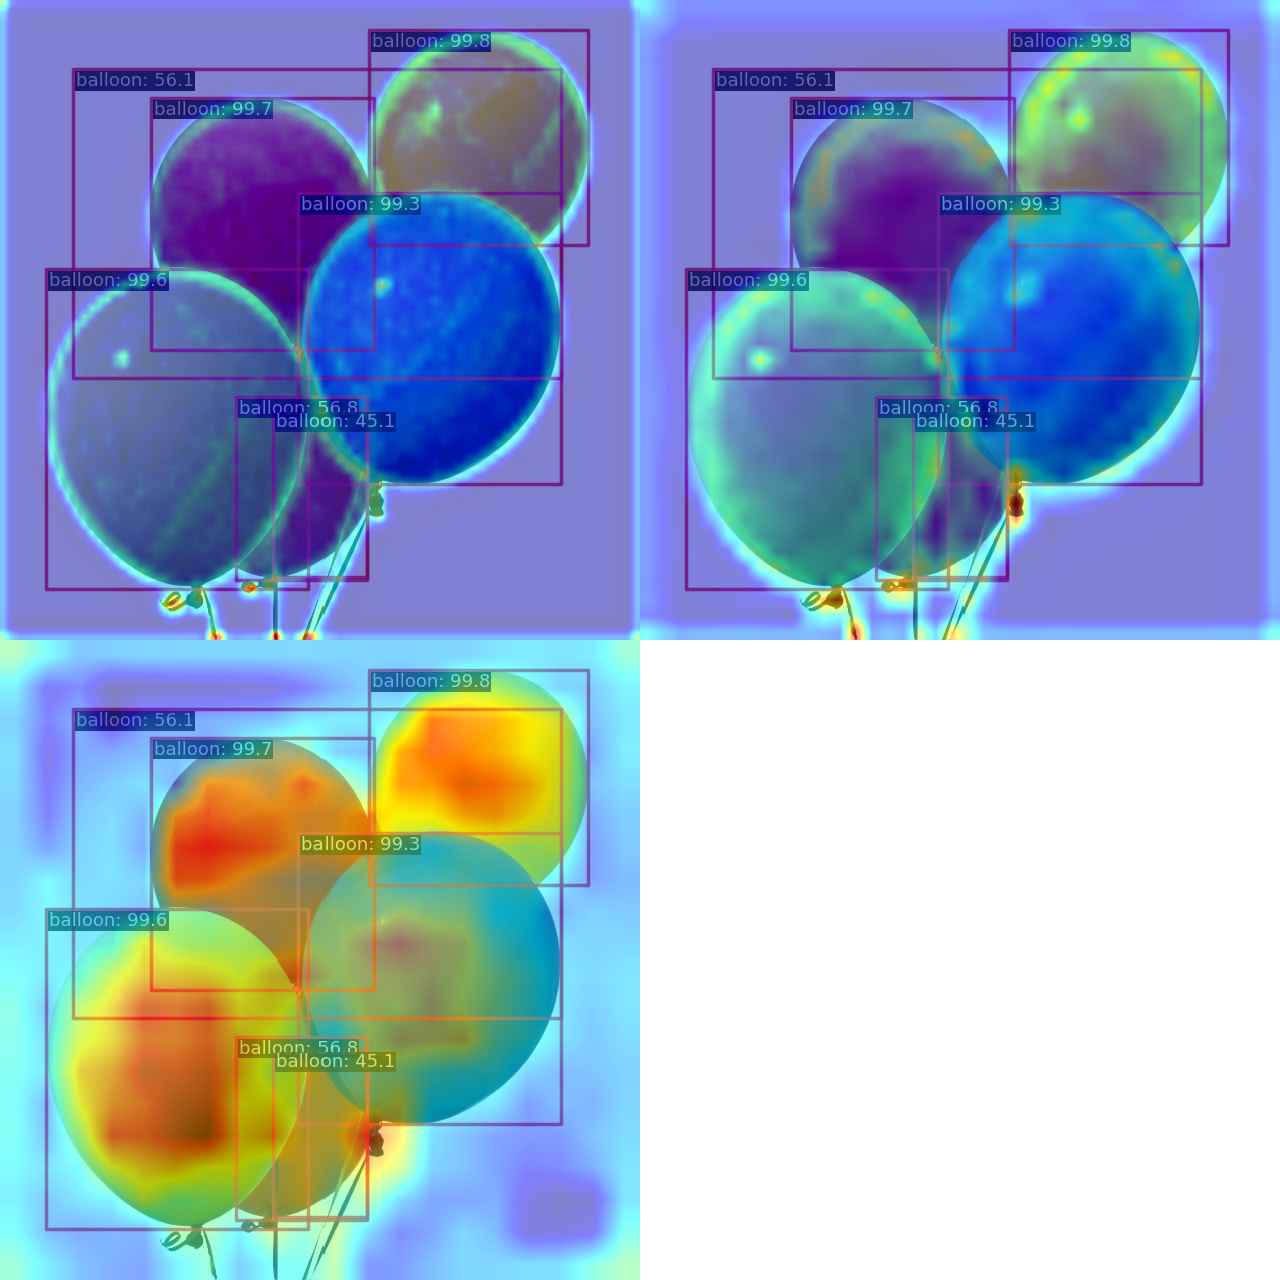

In [40]:
!python demo/featmap_vis_demo.py \
      resized_image.jpg \
      ../mmdetection/projects/balloon-detect-demo/rtmdet_tiny_1xb12-40e_balloon.py \
      ../mmdetection/projects/balloon-detect-demo/work_dirs/rtmdet_tiny_1xb12-40e_balloon/best_coco_bbox_mAP_epoch_30.pth  \
      --target-layers backbone  \
      --channel-reduction squeeze_mean
Image.open('output/resized_image.jpg')     

上图中绘制的 3 个输出特征图对应大中小输出特征图。由于本次训练的 backbone 实际上没有参与训练，从上图可以看到，大物体 cat 是在小特征图进行预测，这符合目标检测分层检测思想。

可视化 neck 输出的 3 个通道

Loads checkpoint by local backend from path: ../mmdetection/projects/balloon-detect-demo/work_dirs/rtmdet_tiny_1xb12-40e_balloon/best_coco_bbox_mAP_epoch_30.pth
06/11 16:32:48 - mmengine - WARNING - `Visualizer` backend is not initialized because save_dir is None.
[                                                  ] 0/1, elapsed: 0s, ETA:/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/usr/local/lib/python3.10/dist-packages/mmengine/visualization/visualizer.py:984: UserWarning: Since the spatial dimensions of overlaid_image: (640, 640) and featmap: torch.Size([80, 80]) are not same, the feature map will be interpolated. This may cause mismatch problems ！
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/mmengine/visuali

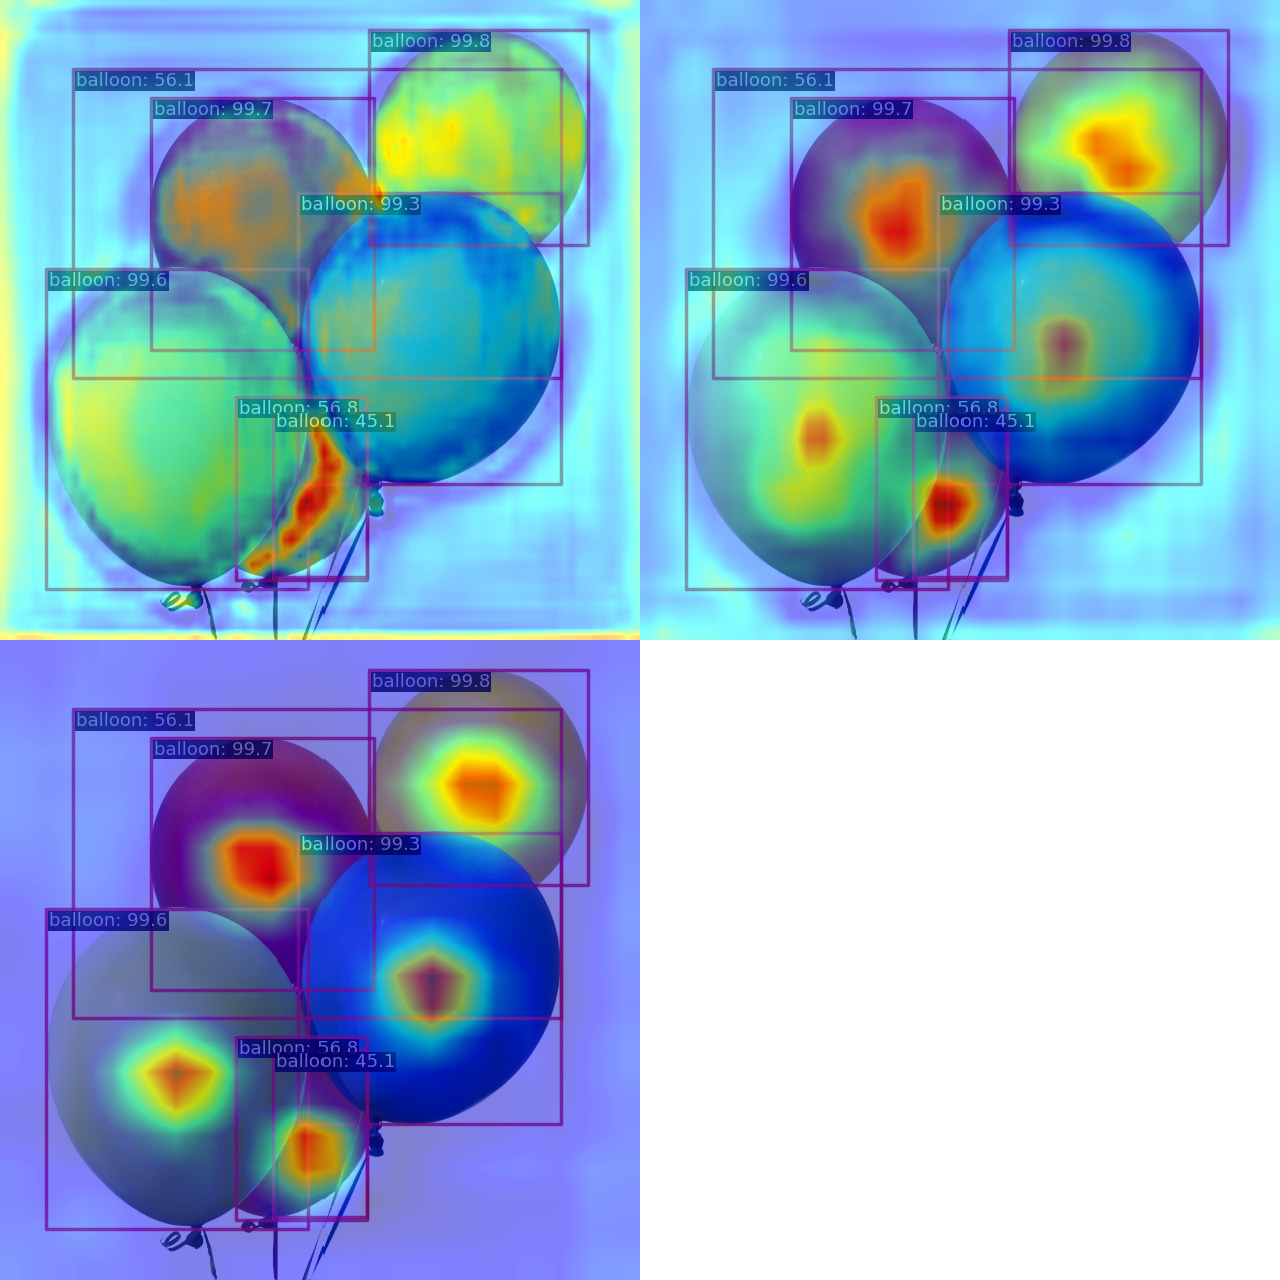

In [43]:
!python demo/featmap_vis_demo.py \
      resized_image.jpg \
      ../mmdetection/projects/balloon-detect-demo/rtmdet_tiny_1xb12-40e_balloon.py \
      ../mmdetection/projects/balloon-detect-demo/work_dirs/rtmdet_tiny_1xb12-40e_balloon/best_coco_bbox_mAP_epoch_30.pth  \
      --target-layers neck  \
      --channel-reduction squeeze_mean
Image.open('output/resized_image.jpg') 

从上图可以看出，由于 neck 是参与训练的，并且 FPN 间的信息融合导致输出特征图更加聚集

**Grad-Based CAM 可视化**

In [42]:
!pip install "grad-cam"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 48.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.6-py3-none-any.whl size=38241 sha256=4ab95a897d0a8eee41cf451d442f7b10baf4c52d9cc87a3819e98775f21466a5
  Stored in directory: /root/.cache/pip/wheels/3c/6c/04/9a543775e9f25f6c441180a552456f1696167439459730ff87
Successfully built grad-cam


a) 查看 neck 输出的最小输出特征图的 Grad CAM

The algorithm currently used is rtmdet
Loads checkpoint by local backend from path: ../mmdetection/projects/balloon-detect-demo/work_dirs/rtmdet_tiny_1xb12-40e_balloon/best_coco_bbox_mAP_epoch_30.pth
[                                                  ] 0/1, elapsed: 0s, ETA:/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
[>>] 1/1, 1.5 task/s, elapsed: 1s, ETA:     0sAll done!
Results have been saved at /content/drive/MyDrive/workspace/mmyolo/output


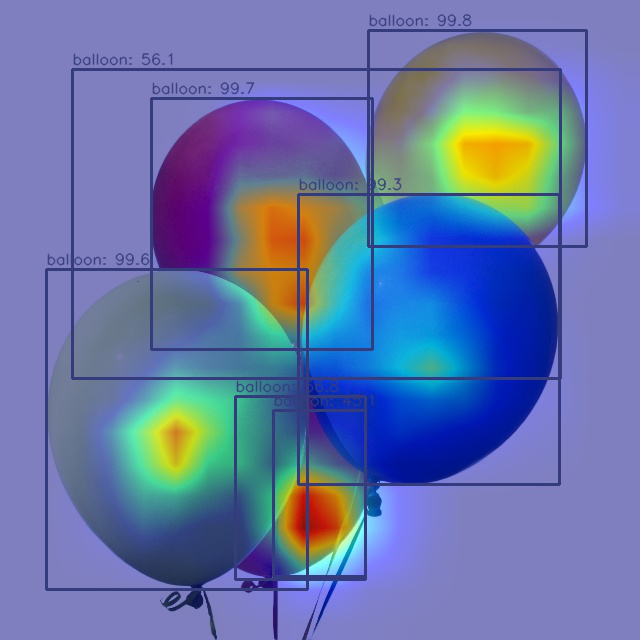

In [44]:
!python demo/boxam_vis_demo.py \
      resized_image.jpg \
      ../mmdetection/projects/balloon-detect-demo/rtmdet_tiny_1xb12-40e_balloon.py \
      ../mmdetection/projects/balloon-detect-demo/work_dirs/rtmdet_tiny_1xb12-40e_balloon/best_coco_bbox_mAP_epoch_30.pth  \
      --target-layer neck.out_convs[2]
Image.open('output/resized_image.jpg')     

可以看出效果较好

b) 查看 neck 输出的最大输出特征图的 Grad CAM

The algorithm currently used is rtmdet
Loads checkpoint by local backend from path: ../mmdetection/projects/balloon-detect-demo/work_dirs/rtmdet_tiny_1xb12-40e_balloon/best_coco_bbox_mAP_epoch_30.pth
[                                                  ] 0/1, elapsed: 0s, ETA:/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
[>>] 1/1, 1.7 task/s, elapsed: 1s, ETA:     0sAll done!
Results have been saved at /content/drive/MyDrive/workspace/mmyolo/output


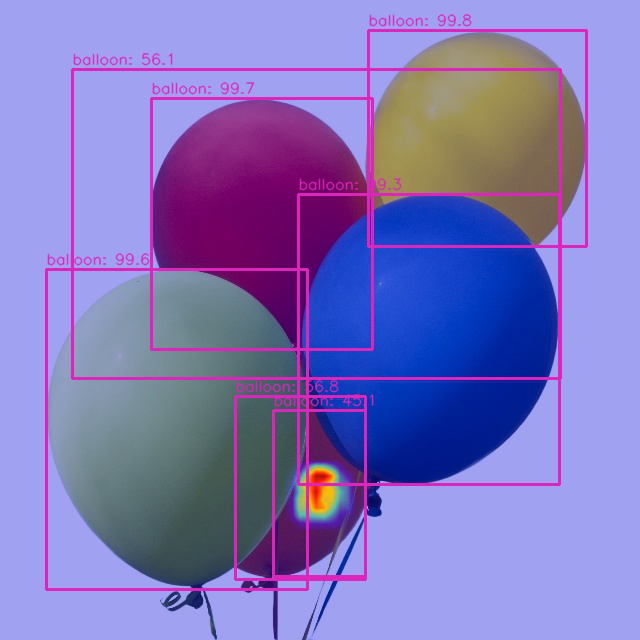

In [45]:
!python demo/boxam_vis_demo.py \
      resized_image.jpg \
      ../mmdetection/projects/balloon-detect-demo/rtmdet_tiny_1xb12-40e_balloon.py \
      ../mmdetection/projects/balloon-detect-demo/work_dirs/rtmdet_tiny_1xb12-40e_balloon/best_coco_bbox_mAP_epoch_30.pth  \
      --target-layer neck.out_convs[0]
Image.open('output/resized_image.jpg')     

可以发现由于大物体不会在该层预测，因此梯度可视化是 0，符合预期。